## Comparing V&A and SMG data

the V&A entity JSON is 4x as large as SMG's, which crashes the EC2 instance, but it's not immediately obvious why

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

### 1. import data

In [1]:
!ls ../GITIGNORE_DATA/vanda_hc_data/hc_import/content/20210705/

events.ndjson        organisations.ndjson
objects.ndjson       persons.ndjson


In [4]:
VANDA_DATA_FOLDER = "../GITIGNORE_DATA/vanda_hc_data/hc_import/content/20210705/"
vanda_filenames = {
    "objects": "objects.ndjson",
    "orgs": "organisations.ndjson",
    "people": "persons.ndjson",
    "events": "events.ndjson",
}

vanda_data = dict()

for k, v in vanda_filenames.items():
    vanda_data[k] = pd.read_json(VANDA_DATA_FOLDER+v, lines=True)
    print(f'imported {k}')

imported objects
imported orgs
imported people
imported events


In [5]:
!ls ../GITIGNORE_DATA/smg-datasets-private/

DESC-CATALOGUE.txt
DESC-PEOPLE.txt
MIMSY-OBJECT-SQL.txt
MIMSY_PEOPLE_SQL.txt
README.md
adlib-document-dump-relevant-columns.csv
azmy matching entities across different knowledge graphs.pdf
itemnames_links.csv
items_makers.csv
items_users.csv
items_users_unsorted_MKEY.csv
mimsy-catalogue-export.csv
mimsy-people-export.csv
samples
wikidatacapture_151020.csv
wikidatacapture_plus_kd_links_121120.csv


In [10]:
SMG_DATA_FOLDER = "../GITIGNORE_DATA/smg-datasets-private/"
smg_filenames = {
    "objects": "mimsy-catalogue-export.csv",
    "people_orgs": "mimsy-people-export.csv",
}

smg_data = dict()

for k, v in smg_filenames.items():
    smg_data[k] = pd.read_csv(SMG_DATA_FOLDER+v, low_memory=False)
    print(f'imported {k}')
    
smg_data['people'] = smg_data['people_orgs'][smg_data['people_orgs']['GENDER'].isin(['M', 'F'])]
smg_data['orgs'] = smg_data['people_orgs'][smg_data['people_orgs']['GENDER'].isin(['N'])]

smg_data.pop('people_orgs');

imported objects
imported people_orgs


In [67]:
smg_data['people']['BIOGRAPHY'] = smg_data['people']['DESCRIPTION'] + smg_data['people']['NOTE']
smg_data['orgs']['BIOGRAPHY'] = smg_data['orgs']['DESCRIPTION'] + smg_data['orgs']['NOTE']

vanda_data['objects'].loc[:, "COMBINED_DESCRIPTION"] = vanda_data['objects'][
        ["DESCRIPTION", "PHYS_DESCRIPTION", "PRODUCTION_TYPE"]
    ].apply(lambda x: f"{' '.join(x)}" if any(x) else "", axis=1)

## 2. comparing datasets

### 2.1 sizes

In [13]:
for k in ['people', 'orgs', 'objects']:
    print(f'{k}'.upper())
    print(f'vanda: {len(vanda_data[k])}')
    print(f'smg: {len(smg_data[k])}')

PEOPLE
vanda: 71665
smg: 10352
ORGS
vanda: 20405
smg: 7743
OBJECTS
vanda: 324518
smg: 282259


### 2.2 number of empty descriptions

In [70]:
vanda_missing_people_biogs = (vanda_data['people']['BIOGRAPHY'].apply(len) == 0).sum()
smg_missing_people_biogs = (smg_data['people']['BIOGRAPHY'].fillna("").apply(len) == 0).sum()

vanda_missing_org_biogs = (vanda_data['orgs']['HISTORY'].apply(len) == 0).sum()
smg_missing_org_biogs = (smg_data['orgs']['BIOGRAPHY'].fillna("").apply(len) == 0).sum()

vanda_missing_object_biogs = (vanda_data['objects']['COMBINED_DESCRIPTION'].apply(len) == 0).sum()
smg_missing_object_biogs = (smg_data['objects']['DESCRIPTION'].fillna("").apply(len) == 0).sum()


print(f"vanda people: {vanda_missing_people_biogs} / {len(vanda_data['people'])}")
print(f"smg people: {smg_missing_people_biogs} / {len(smg_data['people'])}")

print(f"vanda orgs: {vanda_missing_org_biogs} / {len(vanda_data['orgs'])}")
print(f"smg orgs: {smg_missing_org_biogs} / {len(smg_data['orgs'])}")

print(f"vanda orgs: {vanda_missing_object_biogs} / {len(vanda_data['objects'])}")
print(f"smg orgs: {smg_missing_object_biogs} / {len(smg_data['objects'])}")


vanda people: 35116 / 71665
smg people: 5347 / 10352
vanda orgs: 11034 / 20405
smg orgs: 2649 / 7743
vanda orgs: 63437 / 324518
smg orgs: 50 / 282259


### 2.2 number of words in descriptions

/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'smg')

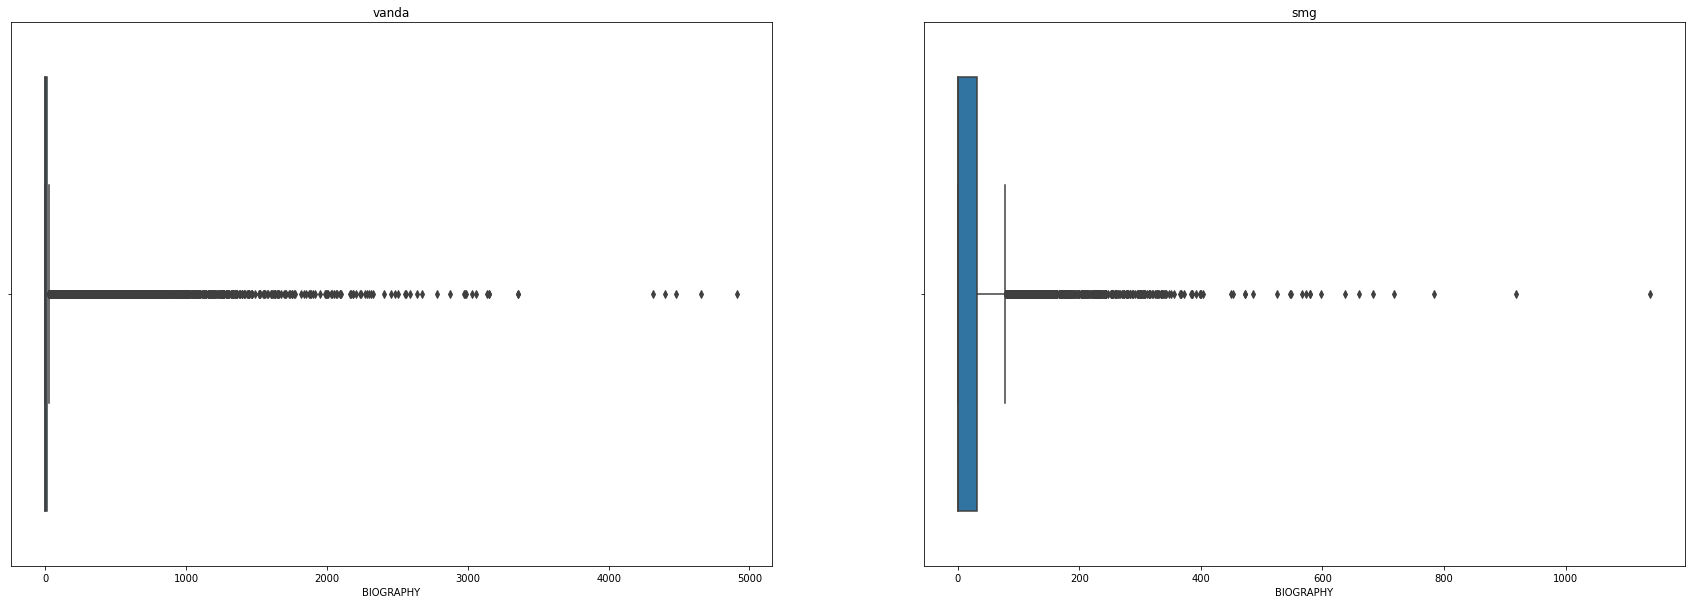

In [33]:
nwords_vanda_people = vanda_data['people']['BIOGRAPHY'].apply(lambda x: len(str(x).split(" ")))
nwords_smg_people = smg_data['people']['BIOGRAPHY'].apply(lambda x: len(str(x).split(" ")))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(30,10))

sns.boxplot(
    nwords_vanda_people, ax=ax1
)
ax1.set_title("vanda")

sns.boxplot(
    nwords_smg_people, ax=ax2
)
ax2.set_title("smg")

In [97]:
vanda_data['objects'][vanda_data['objects']['COMBINED_DESCRIPTION'].apply(lambda x: len(str(x).split(" ")) > 500)].count(), len(vanda_data['objects'])

(URI                     582
 SYSTEM_NUMBER           582
 PRIMARY_TITLE           582
 PRIMARY_PLACE           523
 PRIMARY_DATE            579
 OBJECT_TYPE             582
 DESCRIPTION             582
 PHYS_DESCRIPTION        582
 ACCESSION_NUMBER        582
 COLLECTION              582
 PRODUCTION_TYPE         582
 COMBINED_DESCRIPTION    582
 dtype: int64,
 324518)

In [91]:
vanda_data['people']['BIOGRAPHY_nwords'] = vanda_data['people']['BIOGRAPHY'].apply(lambda x: len(str(x).split(" ")))

with pd.option_context('display.max_colwidth', 500):
    display(vanda_data['people'][vanda_data['people']['BIOGRAPHY']
        .apply(lambda x: len(str(x).split(" "))) > 2000]
        .sort_values('BIOGRAPHY_nwords', ascending=False)[['URI', 'BIOGRAPHY', 'BIOGRAPHY_nwords']])
    
    

,URI,BIOGRAPHY,BIOGRAPHY_nwords
35740,https://api.vam.ac.uk/v2/objects/search?id_person=N4325,"Field of Interest\r\nPolitics, Government and Political Movements\r\nOccupation\r\nStatesman\r\nPlace of\r\n Birth\r\nFarm Bovenplaats, near Riebeek West in the Malmesbury district of the Cape Colony\r\n Education\r\nRiebeek West, Victoria College, Stellenbosch, Christ's College, Cambridge, Middle Temple\r\n Death\r\nOn his farm at Irene, near Pretoria\r\nSpouse\r\nSybella Margaretha (died 1954), daughter of Japie Krige\r\nSources\r\nSarah Gertrude Millin, General Smuts, 1936;...",4912
45890,https://api.vam.ac.uk/v2/objects/search?id_person=A37138,"Mondrian [Mondriaan], Piet(er Cornelis)\r\n(b Amersfoort, 7 March 1872; d New York, 1 Feb 1944).\r\nDutch painter, theorist and draughtsman. His work marks the transition at the start of the 20th century from the Hague school and Symbolism to Neo-Impressionism and Cubism. His key position within the international avant-garde is determined by works produced after 1920. He set out his theory in the periodical of de Stijl, in a series of articles that were summarized in a separate booklet publi...",4653
36443,https://api.vam.ac.uk/v2/objects/search?id_person=N1852,"Field of Interest\r\nLiterature and Writing\r\nOccupation\r\nPoet and novelist\r\nPlace of\r\n Birth\r\nHigher Bockhampton, a hamlet near Stinsford in Dorset\r\n Education\r\nStinsford, Schooling in the village, School, kept by a nonconformist master, in Dorchester, Dorchester, King's College\r\n Death\r\nMax Gate\r\n Burial\r\nWestminster Abbey, Churchyard of Stinsford\r\nSpouse\r\nEmma Lavinia, daughter of John Attersoll Gifford, Florence Emily, daughter of Edward D...",4482
36458,https://api.vam.ac.uk/v2/objects/search?id_person=N1835,"Lee was educated at the City of London School and Balliol College, Oxford. His name was Solomon Lazarus Levi but on the advice of Dr. Benjamin Jowett, the Master of Balliol, he changed his name to Sidney Lee. In 1883, when he was 24, he became assistant Editor of The Dictionary of National Biography, and succeeded Mrs. Leslie Stephen as Editor in 1891. He wrote a Life of Queen Victoria in 1902, and in 1912 he wrote, as a supplement to the Dictionary of National Biography, an article on the l...",4402
35741,https://api.vam.ac.uk/v2/objects/search?id_person=N4324,"Field of Interest\r\nMilitary\r\nOccupation\r\nField-marshal\r\nPlace of\r\n Birth\r\nGolden Bridge House\r\n Education\r\nDay school in Dublin\r\n Death\r\nMentone\r\n Burial\r\nSt. Paul's Cathedral\r\nSpouse\r\nLouisa, daughter of Mr. Alexander Erskine\r\nSources\r\nViscount Wolseley, The Story of a Soldier's Life, 2 vols...\r\nContributor\r\nF. M. [Frederick Barton Maurice]\r\n\r\n Article\r\nWolseley, Garnet Joseph, first Viscount Wolseley 1833-1913, field-marshal, the eldest...",4312
36467,https://api.vam.ac.uk/v2/objects/search?id_person=N1826,"Field of Interest\r\nLiterature and Writing\r\nOccupation\r\nPoet laureate\r\nPlace of\r\n Birth\r\nWalmer\r\n Education\r\nEton, Corpus Christi College, St. Bartholomew's Hospital, Germany\r\n Death\r\nChilswell\r\nSpouse\r\nMonica, eldest daughter of his neighbour, the architect Alfred Waterhouse\r\nSources\r\nThe Times, 22 April 1930; Bridges's published writings;...\r\nContributor\r\nN. C. Smith.\r\n\r\n Article\r\nBridges, Robert Seymour 1844-1930, poet laureate, was born...",3359
35541,https://api.vam.ac.uk/v2/objects/search?id_person=N4551,"Bennett, (Enoch) Arnold (1867-1931), writer, was born at Hope Street, Burslem, Staffordshire, on 27 May 1867.\r\nFamily, education, and early life\r\nArnold Bennett was the eldest child in a family of three sons and three daughters—three other children died in infancy—of Enoch Bennett (1843–1902) and Sarah Ann (1840–1914), eldest daughter of Robert Longson, who started life as a weaver in Glossop and moved to Burslem in 1860, where he set up a tailor's shop. According to his son, Enoch had b...",3357
26390,https://api.vam.ac.uk/v2/objects/search?id_p